<a href="https://colab.research.google.com/github/allen17mv/Machine-Learning-Mini-Proj/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import os

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
transform = transforms.Compose([ transforms.ToTensor(), 
                              transforms.Normalize(mean=0.5,std=0.5)])

In [3]:
train_dataset = MNIST(train = True, transform = transform, root = os.getcwd(), download=True)
test_dataset = MNIST(train = False, transform = transform, root = os.getcwd(), download=True)

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


In [4]:
print("Train dataset : ", train_dataset)
print("Test dataset : ", test_dataset)

Train dataset :  Dataset MNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Test dataset :  Dataset MNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [5]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle = True)

In [6]:
train_iterator = iter(train_loader)
train_batch = next(train_iterator)
for item in train_batch:
  print(item.size())

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [7]:
def plot_images(batch):
  img_grid = make_grid(batch[0],nrow=4)
  img_np = img_grid.numpy()
  img_np = np.transpose(img_np,(1,2,0))
  mean=0.5
  std=0.5
  img_np = img_np * std + mean
  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.title(batch[1])
  plt.xticks([])
  plt.yticks([])
  plt.plot()


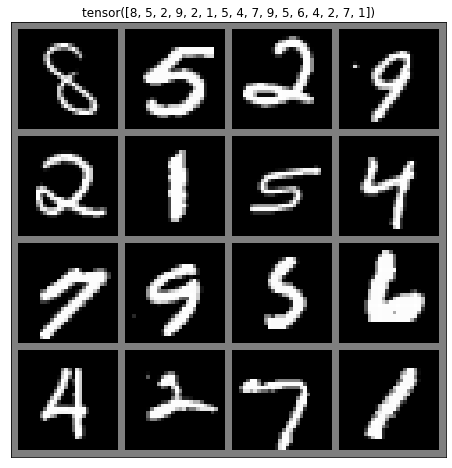

In [8]:
plot_images(train_batch)


In [9]:
flatten = nn.Flatten()
flatten(train_batch[0]).size()

torch.Size([16, 784])

In [10]:
model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784,out_features=200),
        nn.ReLU(),
        nn.Linear(in_features=200,out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100,out_features=60),
        nn.ReLU(),
        nn.Linear(in_features=60,out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30,out_features=10),
        nn.Softmax(dim=1))
    
model

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=60, bias=True)
  (6): ReLU()
  (7): Linear(in_features=60, out_features=30, bias=True)
  (8): ReLU()
  (9): Linear(in_features=30, out_features=10, bias=True)
  (10): Softmax(dim=1)
)

In [11]:
pred_batch = model(train_batch[0])
print(pred_batch.size())

torch.Size([16, 10])


In [12]:
pred_labels = torch.argmax(pred_batch,axis=1)
print(pred_labels)

tensor([2, 9, 9, 9, 9, 9, 2, 9, 2, 9, 2, 9, 9, 9, 9, 2])


In [13]:
loss_criterion = nn.CrossEntropyLoss()

In [14]:
loss_criterion(pred_batch,train_batch[1])

tensor(2.3000, grad_fn=<NllLossBackward>)

In [15]:
def evaluate_on_gpu(model,dataloader):
  with torch.no_grad():
    total,correct=0,0
    for batch in dataloader:
      images, labels = batch
      images, labels = images.to(device),labels.to(device)
      out_probs = model(images)
      out_labels = torch.argmax(out_probs,axis=1)
      total += labels.size(0)
      correct += torch.sum(labels == out_labels).item()
  return 100*correct/total

def train_on_gpu(model,model_name,loss_criterion,optimizer,train_loader,test_loader,epochs=10):
  hist = { 'loss':[], 'train_acc' : [] , 'test_acc' : []}
  min_loss = 10e+10
  for epoch_num in tqdm(range(1,epochs+1),desc='Training', total = epochs):
    losses =[]
    for batch in train_loader:
      images, labels = batch
      images, labels = images.to(device),labels.to(device)
      optimizer.zero_grad()
      out = model(images)
      loss = loss_criterion(out,labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
      epoch = np.array(losses).mean()
    hist['loss'].append(epoch)

    if epoch<min_loss:
      min_loss = epoch
      torch.save(model.state_dict(),model_name +'.pth')
    train_acc = evaluate_on_gpu(model,train_loader)
    test_acc = evaluate_on_gpu(model,test_loader)
    hist['train_acc'].append(train_acc) 
    hist['test_acc'].append(test_acc)

  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
  ax[0].plot(range(1,epochs+1),hist['loss'],label='Loss')
  ax[0].plot(range(1,epochs+1),np.ones(shape=(epochs,))*min_loss, 'r--',alpha=0.5,label='Best Loss')
  ax[0].grid()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss Value')
  ax[0].set_title('Epochs Vs Loss')

  ax[1].plot(hist['train_acc'], 'b-', label='Training Accuracy')
  ax[1].plot(hist['test_acc'],'m-',alpha=0.5,label='Test Accuracy')
  ax[1].grid()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Epochs Vs Accuracy')
  plt.legend()
  plt.show()




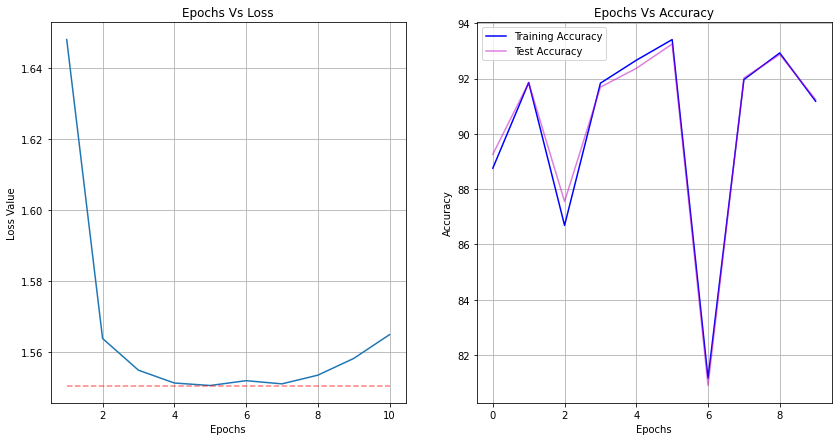

In [16]:
model = model.to(device)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
model = train_on_gpu(model,'mnist',loss_criterion,optimizer,train_loader, test_loader)